## Reconstruction Triangulation Sandbox

Author: Dane

### Purpose
Create simple samples that can be used to understand the algorithms and challenges inherent to the structure from motion problem using toy examples, exposing functionality



In [16]:
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import csv
import cv2 as cv
np.set_printoptions(suppress=True)

def Lounguent_Higgins_Fundamental_Matrix(hn_pts_a, hn_pts_b):
    
    assert (len(hn_pts_a) == len(hn_pts_b)), 'Correspondence points do not match in number between images'
    num_correspondences = len(hn_pts_a)
    
    A = np.zeros((num_correspondences, 8), dtype=np.float32)
    B = np.zeros((num_correspondences, 1), dtype=np.float32)
    
    for no in range( num_correspondences ):
        
        A[no,0] = hn_pts_a[no].x * hn_pts_b[no].x
        A[no,1] = hn_pts_a[no].x * hn_pts_b[no].y
        A[no,2] = hn_pts_a[no].x 
        A[no,3] = hn_pts_a[no].y * hn_pts_b[no].x

        A[no,4] = hn_pts_a[no].y * hn_pts_b[no].y
        A[no,5] = hn_pts_a[no].y
        A[no,6] = hn_pts_b[no].x
        A[no,7] = hn_pts_b[no].y
        
        B[no,0] = -1

    
    # Compute the least squares solution [ X = (A^T @ A)^-1 @ A^T @ B ]     < np.linalg.lstsq(A, B) >
    lst_squ = np.linalg.inv(np.transpose(A) @ A) @ np.transpose(A) @ B
    
    lst_squ = np.concatenate( (lst_squ, np.array([[1.0]], dtype=np.float32)), axis=0)
    lst_squ = np.reshape(lst_squ, (3,3))

    return lst_squ

def Find_Fundamental_Matrix_With_SVD(hn_pts_a, hn_pts_b):
    
    assert (len(hn_pts_a) == len(hn_pts_b)), 'Correspondence points do not match in number between images'
    num_correspondences = len(hn_pts_a)
    
    A = np.zeros((num_correspondences, 9), dtype=np.float32)
    B = np.zeros((num_correspondences, 1), dtype=np.float32)
    
    for no in range( num_correspondences ):
        
        A[no,0] = hn_pts_a[no].x * hn_pts_b[no].x
        A[no,1] = hn_pts_a[no].x * hn_pts_b[no].y
        A[no,2] = hn_pts_a[no].x 
        A[no,3] = hn_pts_a[no].y * hn_pts_b[no].x
        A[no,4] = hn_pts_a[no].y * hn_pts_b[no].y
        A[no,5] = hn_pts_a[no].y
        A[no,6] = hn_pts_b[no].x
        A[no,7] = hn_pts_b[no].y
        A[no,8] = 1.0
        
        B[no,0] = 0

    
    # Condition so F is of rank 8, not 9
    U, S, V_T = np.linalg.svd(A)
        
    S_m = np.zeros( (U.shape[1],9) )
    S[-1] = 0.0
    np.fill_diagonal(S_m, S)    
    A_Prime = U @ S_m @ V_T

    U_Prime, S_Prime, V_T_Prime = np.linalg.svd(A_Prime)
    solution = V_T_Prime[-1]
    
    solution = solution.reshape(3,3)
    
    return solution


class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __str__(self):
        return '{0:.2f}'.format(self.x) + ', ' + '{0:.2f}'.format(self.y)
        
class Snapshot:
    def __init__(self, file_prefix):
        img_path = './samples/' + file_prefix + '.jpg'
        self.img = np.asarray(Image.open(img_path))
        
        csv_path = './samples/' + file_prefix + '.csv'
        self.pts = []
        with open(csv_path, newline='\r\n') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for row in reader:
                x = int(row[0])
                y = int(row[1])
                self.pts.append(Point(x, y))

def display_2_snapshots(snap_a, snap_b):
    f, axarr = plt.subplots(2,2, figsize=(16,16))
    axarr[0,0].imshow(snap_a.img)
    axarr[0,0].set_axis_off()
    axarr[0,0].set_title('First Image', y=-.18)
    axarr[0,1].imshow(snap_b.img)
    axarr[0,1].set_axis_off()
    axarr[0,1].set_title('Second Image', y=-.18)
    
    axarr[1,0].imshow(snap_a.img)
    axarr[1,0].set_axis_off()
    axarr[1,0].set_title('First Key Points', y=-.18)
    a_x = [pt.x for pt in snap_a.pts]
    a_y = [pt.y for pt in snap_a.pts]
    axarr[1,0].scatter(a_x, a_y, marker="x")
    
    axarr[1,1].imshow(snap_b.img)
    axarr[1,1].set_axis_off()
    axarr[1,1].set_title('Second Key Points', y=-.18)    
    b_x = [pt.x for pt in snap_b.pts]
    b_y = [pt.y for pt in snap_b.pts]
    axarr[1,1].scatter(b_x, b_y, marker="x")
    
def hartley_normalization(all_snapshot_pts):
    
    # Find new centroid
    avg_x = 0.0
    avg_y = 0.0
    for pt in all_snapshot_pts:
        avg_x += pt.x
        avg_y += pt.y
    
    avg_x /= len(all_snapshot_pts)
    avg_y /= len(all_snapshot_pts)

#     avg_x = 0.0 # DEBUG
#     avg_y = 0.0 # DEBUG

    
    # Re-Center points, record avg distance from center
    normalized_pts = []
    avg_dist_from_center = 0.0
    for pt in all_snapshot_pts:
        n_x = pt.x - avg_x
        n_y = pt.y - avg_y
        normalized_pts.append( Point(n_x, n_y) )

        avg_dist_from_center += ( np.sqrt(n_x*n_x + n_y*n_y) )
    
    avg_dist_from_center /= ( len(all_snapshot_pts) )
    
    # Scale points so avg pt distance becomes 'sqrt(2)'
    scale_factor = np.sqrt(2) / avg_dist_from_center
#     scale_factor = 1.0 # DEBUG
    for i in range( (len(normalized_pts)) ):
        normalized_pts[i].x *= scale_factor
        normalized_pts[i].y *= scale_factor
        
        
    # Calculate inverse transform of shape 3x3 (Homogeneous)
    inverse_normalize = np.array([
        [ 1.0/scale_factor,   0.0,                avg_x ],
        [ 0.0,                1.0/scale_factor,   avg_y ],
        [ 0.0,                0.0,                1.0   ]
    ])
        
        
    return normalized_pts, inverse_normalize

## N64 Correspondence Example

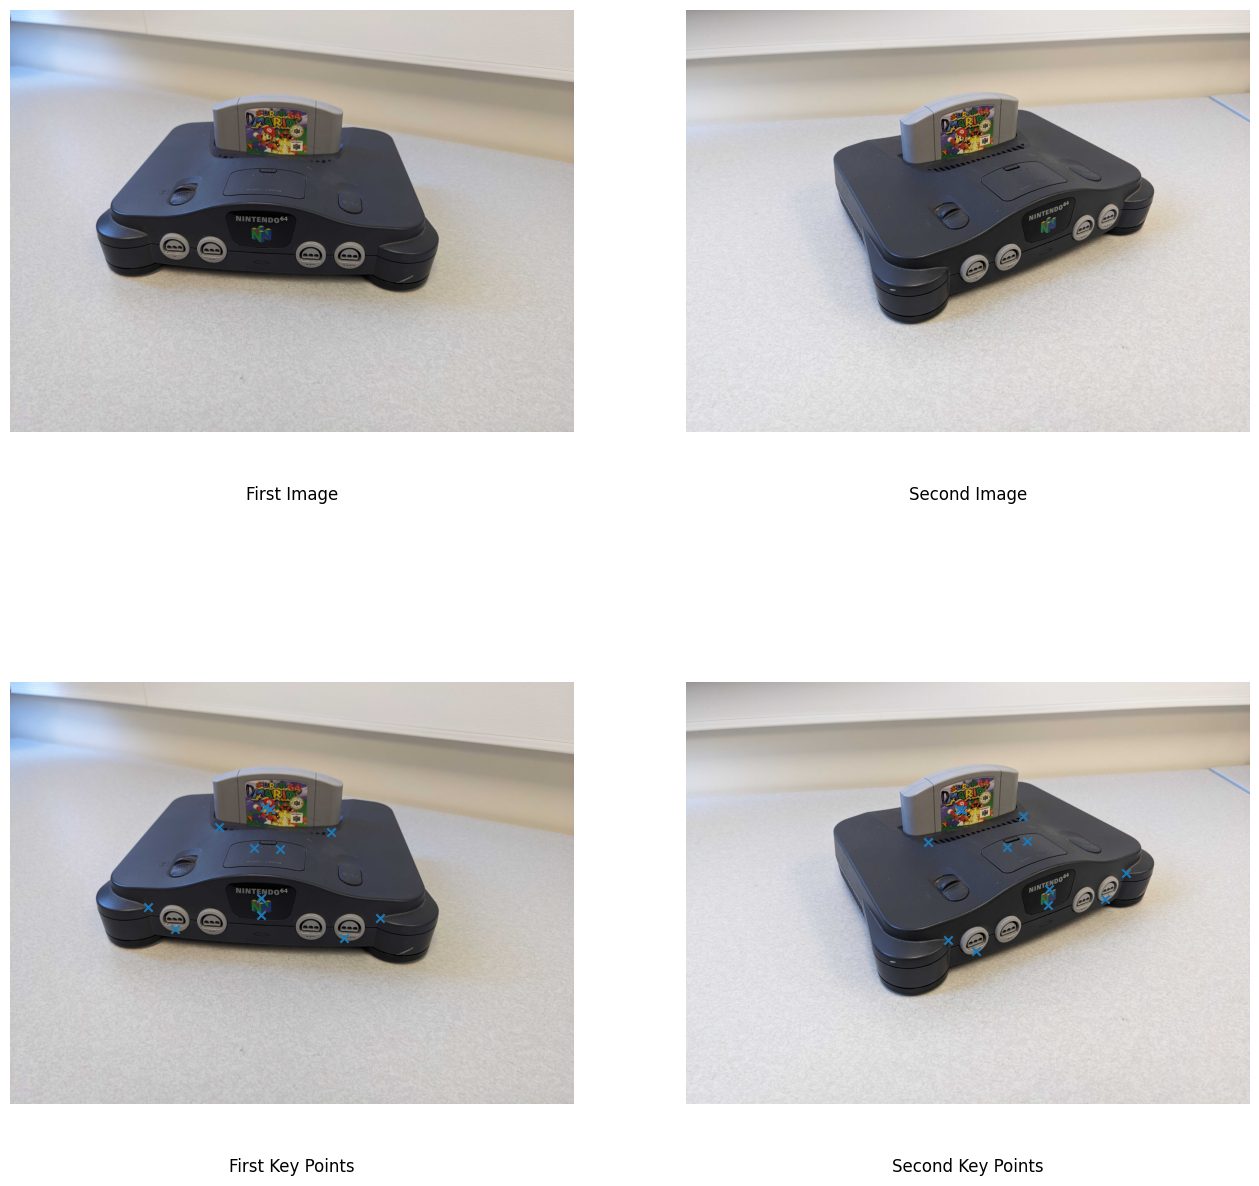

In [17]:
n64_a = Snapshot('N64_A')
n64_b = Snapshot('N64_B')

display_2_snapshots(n64_a, n64_b)

## Camera Calibration and Triangulation Example

Fundamental matrix is:
 [[ 0.00002725  0.01878015  0.14325907]
 [ 0.01800735  0.01053112 -0.69130186]
 [ 0.0909194   0.70172929 -0.01001889]]


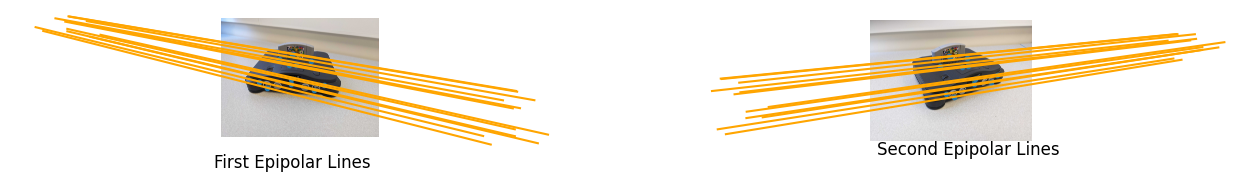

In [18]:
def get_epipolar_line_points(e_line, x_offset, hn_pt, inv_h_norm):
    
    x_s = []
    y_s = []

    A = e_line[0][0]
    B = e_line[1][0]
    C = e_line[2][0]
    
    pt_1 = np.array([
                        hn_pt.x + x_offset, 
                        ( -A * (hn_pt.x + x_offset) - C ) / B,
                        1.0
                    ])

    pt_2 = np.array([
                        hn_pt.x - x_offset, 
                        ( -A * (hn_pt.x - x_offset) - C ) / B,
                        1.0
                    ])

    pt_1 = inv_h_norm @ pt_1
    pt_2 = inv_h_norm @ pt_2

    x_s.append(pt_1[0])
    y_s.append(pt_1[1])
    x_s.append(pt_2[0])
    y_s.append(pt_2[1])

        
    return x_s, y_s
        
    
def render_epipolar_lines(F, snap_a, hn_pts_a, inv_h_norm_a, snap_b, hn_pts_b, inv_h_norm_b):
    
    # Calculate the two epipolar lines we get out
    # F*p'  = epipolar line in  the first image (Normalized Hartley Coordiantes)
    # F^T*p = epipolar line in the second image (Normalized Hartley Coordiantes)

    num_correspondence_points = len(hn_pts_a)

    
    # Draw correspondence points for first image
    f, axarr = plt.subplots(1,2, figsize=(16,16))
    axarr[0].imshow(snap_a.img)
    axarr[0].set_axis_off()
    axarr[0].set_title('First Epipolar Lines', y=-.18)
    a_x = [pt.x for pt in snap_a.pts]
    a_y = [pt.y for pt in snap_a.pts]
    axarr[0].scatter(a_x, a_y, marker=".")

    # Superimpose lines
    for i in range(num_correspondence_points):
        e_line_a = F @ np.array([
                                        [hn_pts_b[i].x], 
                                        [hn_pts_b[i].y], 
                                        [1.0]
                                    ], dtype=np.float32)
        
        x1_s, y1_s = get_epipolar_line_points(e_line_a, 16.0, hn_pts_a[i], inv_h_norm_a)
        axarr[0].plot(x1_s, y1_s, color='orange')
    
    
    # Draw correspondence points for second image
    axarr[1].imshow(snap_b.img)
    axarr[1].set_axis_off()
    axarr[1].set_title('Second Epipolar Lines', y=-.18)    
    b_x = [pt.x for pt in snap_b.pts]
    b_y = [pt.y for pt in snap_b.pts]
    axarr[1].scatter(b_x, b_y, marker=".")

    # Superimpose lines
    for i in range(num_correspondence_points):
        e_line_b = np.transpose(F) @ np.array([
                                            [hn_pts_a[i].x], 
                                            [hn_pts_a[i].y], 
                                            [1.0]
                                        ], dtype=np.float32)

        x2_s, y2_s = get_epipolar_line_points(e_line_b, 16.0, hn_pts_b[i], inv_h_norm_b)
        axarr[1].plot(x2_s, y2_s, color='orange')

    

    
    
    
# Use Hartley's method of normalizing points before estimating matrix 'F'
hn_pts_a, inv_h_norm_a = hartley_normalization(n64_a.pts)
hn_pts_b, inv_h_norm_b = hartley_normalization(n64_b.pts)

# For 8-point algorithm use 'Lounguent_Higgins_Fundamental_Matrix' with same parameters
# F = Lounguent_Higgins_Fundamental_Matrix(hn_pts_a, hn_pts_b)
F = Find_Fundamental_Matrix_With_SVD(hn_pts_a, hn_pts_b)

print('Fundamental matrix is:\n', F)


render_epipolar_lines(F, n64_a, hn_pts_a, inv_h_norm_a, n64_b, hn_pts_b, inv_h_norm_b)



